In [74]:
import george
import numpy as np
import matplotlib.pyplot as plt
from george import kernels
from scipy.optimize import minimize
import pickle
from astropy.table import Column
from astropy.table import Table
%matplotlib inline

# Preparing the input data set Y


Y has dimensions N x D -- with N is the number of objects, D is the number of dimensions (i.e. pixels). 

Y_err is the noise vector of the spectra, and has the same dimensions. 

In [281]:
# loading training labels
f = open('/Users/eilers/Dropbox/cygnet/data/training_labels_apogee_tgas.pickle', 'r')
training_labels = pickle.load(f)
f.close()

# loading normalized spectra
f = open('/Users/eilers/Dropbox/cygnet/data/apogee_spectra_norm.pickle', 'r')    
spectra = pickle.load(f)
f.close()

wl = spectra[:, 0, 0]
fluxes = spectra[:, :, 1].T
ivars = (1./(spectra[:, :, 2]**2)).T 

In [10]:
# remove duplicates       
foo, idx = np.unique(training_labels['APOGEE_ID'], return_index = True)
training_labels = training_labels[idx]
fluxes = fluxes[idx, :]
ivars = ivars[idx, :]
        
# data masking       
masking = training_labels['K'] < 0.
training_labels = training_labels[~masking]
fluxes = fluxes[~masking]
ivars = ivars[~masking]

# scaling of data and training labels?!

In [11]:
# calculate K_MAG_ABS and Q

Q = 10**(0.2*training_labels['K']) * training_labels['parallax']/100.                    # assumes parallaxes is in mas
Q_err = training_labels['parallax_error'] * 10**(0.2*training_labels['K'])/100. 
Q = Column(Q, name = 'Q_MAG')
Q_err = Column(Q_err, name = 'Q_MAG_ERR')
training_labels.add_column(Q, index = 12)
training_labels.add_column(Q_err, index = 13)

In [12]:
# latex

latex = {}
latex["TEFF"] = r"$T_{\rm eff}$"
latex["LOGG"] = r"$\log g$"
latex["FE_H"] = r"$\rm [Fe/H]$"
latex["ALPHA_M"] = r"$[\alpha/\rm M]$"
latex["C_FE"] = r"$\rm [C/Fe]$"
latex["N_FE"] = r"$\rm [N/Fe]$"
latex["Q_MAG"] = r"$Q$"

In [13]:
def make_label_input(labels, training_labels):
    tr_label_input = np.array([training_labels[x] for x in labels]).T
    tr_ivar_input = 1./((np.array([training_labels[x+'_ERR'] for x in labels]).T)**2)
    for x in range(tr_label_input.shape[1]):
        bad = np.logical_or(tr_label_input[:, x] < -100., tr_label_input[:, x] > 9000.) # magic
        tr_label_input[bad, x] = np.median(tr_label_input[:, x])
        tr_ivar_input[bad, x] = 0.
    # remove one outlier in T_eff and [N/Fe]!
    bad = tr_label_input[:, 0] > 5200.
    tr_label_input[bad, 0] = np.median(tr_label_input[:, 0])
    tr_ivar_input[bad, 0] = 0.  
    bad = tr_label_input[:, 5] < -0.6
    tr_label_input[bad, 5] = np.median(tr_label_input[:, 5])
    tr_ivar_input[bad, 5] = 0.     
    return tr_label_input, tr_ivar_input

In [19]:
labels = np.array(['TEFF', 'FE_H', 'LOGG', 'ALPHA_M', 'Q_MAG', 'N_FE', 'C_FE'])
Nlabels = len(labels)
latex_labels = [latex[l] for l in labels]
tr_label_input, tr_ivar_input = make_label_input(labels, training_labels)
print(Nlabels, tr_label_input.shape, tr_ivar_input.shape, fluxes.shape, ivars.shape)

(7, (2180, 7), (2180, 7), (2180, 8575), (2180, 8575))


# GP for one stellar spectrum, in analogy to Dan's example...

In [236]:
# take only subset of data set for the moment...
Y = fluxes[10, 500:675]
Y_err = 1./np.sqrt(ivars[10, 500:675])
x = wl[500:675]

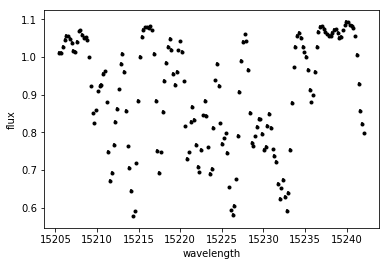

In [237]:
plt.errorbar(x, Y, yerr = Y_err, fmt=".k", capsize=0)
plt.xlabel('wavelength')
plt.ylabel('flux')

In [282]:
# define kernel
kernel = np.var(Y) * kernels.ExpSquaredKernel(metric = 1., ndim = 1)

In [283]:
gp = george.GP(kernel)
gp.compute(x, Y_err) 
# PROBLEM: can't take Y_err for N>1...

x_pred = np.linspace(x[0], x[-1], 500)
pred, pred_var = gp.predict(Y, x_pred, return_var=True)

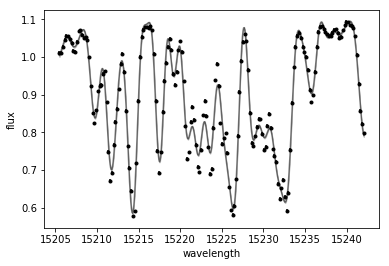

In [266]:
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, Y, yerr=Y_err, fmt=".k", capsize=0)
plt.xlabel('wavelength')
plt.ylabel('flux')

In [267]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(Y)))

Initial ln-likelihood: -3272.87


In [268]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(Y) # + prior on latent space!

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(Y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(Y)))

      fun: -334.09339482193735
 hess_inv: array([[ 0.03089232,  0.00325671],
       [ 0.00325671,  0.00123315]])
      jac: array([ -6.05251955e-08,   3.60782724e-06])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 13
     njev: 15
   status: 0
  success: True
        x: array([-0.94392633, -1.06360424])

Final ln-likelihood: 334.09


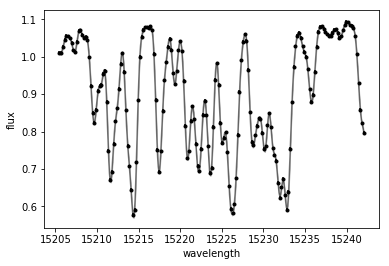

In [269]:
pred, pred_var = gp.predict(Y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, Y, yerr=Y_err, fmt=".k", capsize=0)
plt.xlabel('wavelength')
plt.ylabel('flux')

# Questions... 

How can I define how many parameters/latent dimensions the model should have? At the moment it's 2...

# GPLVM...

In [284]:
# take only subset of data set for the moment...
Y = fluxes[:100, 500:700]
Y_err = 1./np.sqrt(ivars[:100, 500:700])
x = wl[500:700]
N = Y.shape[0]
D = Y.shape[1]

# latent dimension
Q = 3

In [285]:
# define kernel
kernel = kernels.ExpSquaredKernel(metric = 1., ndim = D)

QUESTIONS

Which dimensions should the kernel have? D x Q, I think... At the moment, only D x 1?

Can I use the Local Gaussian kernel to add prior on latent space?!

Can we constrain the latent space with the metric by setting it to the covariance matrix of the labels?

In [146]:
# likelihood function
def new_log_likelihood(Y, X):
    log_like_tot = gp.log_likelihood(Y) + prior on latent space!
    return log_like_tot

# derivatives of likelihood function with respect to X